In [1]:
!pip install torch
!pip install matplotlib

In [2]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt


In [50]:
#vamos aproximar um reta 2x + 1

class LineNetWork(nn.Module):
    def __init__(self):
        super().__init__()
        #vamos criar uma camada linear
        self.linear_layer = nn.Sequential(
            #entra um numero, sai 1 numero
            nn.Linear(in_features=1, out_features=1)
        )

    def forward(self, x): # andar para frente
        return self.linear_layer(x)


In [51]:
# construindo data set
from torch.utils.data import DataLoader, Dataset
from torch.distributions import Uniform as urand

class Data(Dataset):
    def __init__(self, f, interval, sample):
        self.size = sample
        # Pass the lower and upper bounds of the interval as separate arguments
        X = urand(interval[0], interval[1]).sample((self.size,))
        self.data = [(x, f(x)) for x in X]


    def __len__(self):
        return len(self.data)


    def __getitem__(self, index):
        return self.data[index]

In [52]:
line = lambda x: 2*x + 1
interval = (-10, 10)
train_sample = 1000
test_sample = 1000

train_data = Data(line, interval, train_sample)
test_data = Data(line, interval, test_sample)


In [53]:
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=True)

In [54]:
device = "cpu"

In [55]:
# modelo
modelo = LineNetWork().to(device)

# funcao erro
loss_fn = nn.L1Loss()

# otimizador
optimizer = torch.optim.SGD(modelo.parameters())



In [56]:
#treinar
def train(modelo, dataloader, loss_fn, optimizer):
    modelo.train()
    cumLoss = 0
    for x,y in dataloader:
        x = x.unsqueeze(1).float().to(device)
        y = y.unsqueeze(1).float().to(device)

        # prevendo os valores
        pred = modelo(x)
        loss = loss_fn(pred, y)

        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        cumLoss += loss.item()
    return cumLoss/len(dataloader)

def test(modelo, dataloader, loss_fn):
    modelo.eval()
    cumLoss = 0

    for x,y in dataloader:
        x = x.unsqueeze(1).float().to(device)
        y = y.unsqueeze(1).float().to(device)

        # prevendo os valores
        pred = modelo(x)
        loss = loss_fn(pred, y)

        cumLoss += loss.item()
    return cumLoss/len(dataloader)

In [57]:
def plot(f, modelo, interval=(-10, 10), nsample=10):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.grid()
    x = np.linspace(interval[0], interval[1], nsample)
    modelo.eval()

    with torch.no_grad():
        y = modelo(torch.tensor(x).unsqueeze(1).float().to(device))

    ax.plot(x, list(map(f, x)),'bo',label="Real")
    plt.legend()
    ax.plot(x, y.cpu().numpy(), label="Previsto")
    plt.legend()


Epoca 0 - Loss: 8.874477222561836
Epoca 10 - Loss: 1.4246122315526009
Epoca 20 - Loss: 1.015445401892066
Epoca 30 - Loss: 0.7171117831021547
Epoca 40 - Loss: 0.4314432330429554
Epoca 50 - Loss: 0.13542877114377916
Epoca 60 - Loss: 0.01297206454910338
Epoca 70 - Loss: 0.013067147927358747
Epoca 80 - Loss: 0.013027205946855247
Epoca 90 - Loss: 0.012838051887229085
Epoca 100 - Loss: 0.013058258511591703
Epoca 110 - Loss: 0.012790141860023141
Epoca 120 - Loss: 0.012586436176206917
Epoca 130 - Loss: 0.012643391382880509
Epoca 140 - Loss: 0.01323043933371082
Epoca 150 - Loss: 0.013466525706462562
Epoca 160 - Loss: 0.01368221006123349
Epoca 170 - Loss: 0.012705110537353903
Epoca 180 - Loss: 0.013132068153936416
Epoca 190 - Loss: 0.012995460245292634
Epoca 200 - Loss: 0.012577858928125352


<ipython-input-57-b80c5992c40a>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(10, 10))


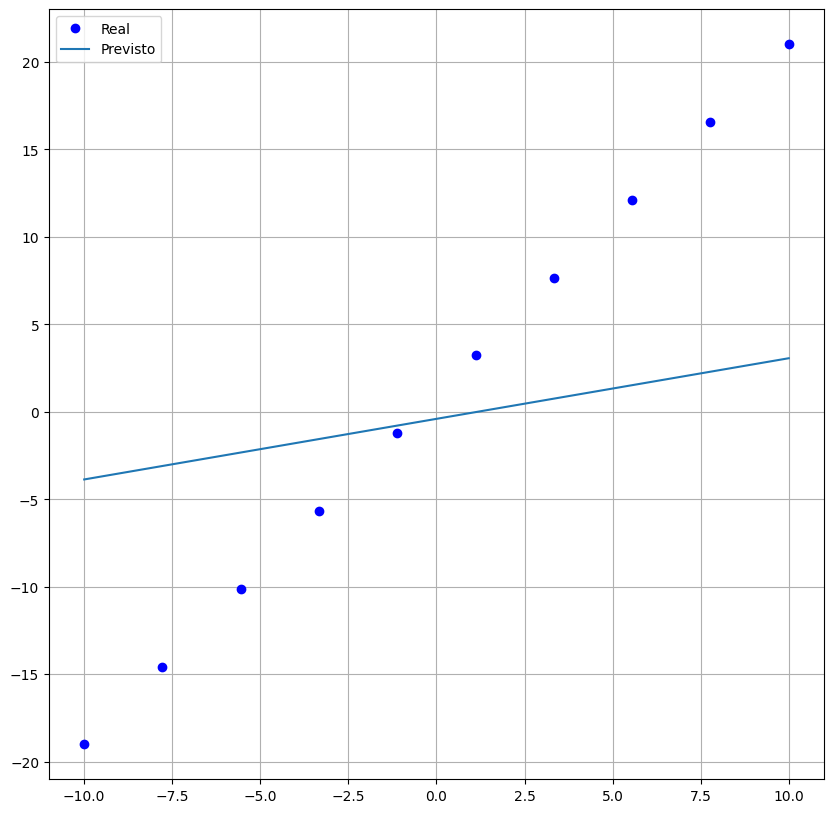

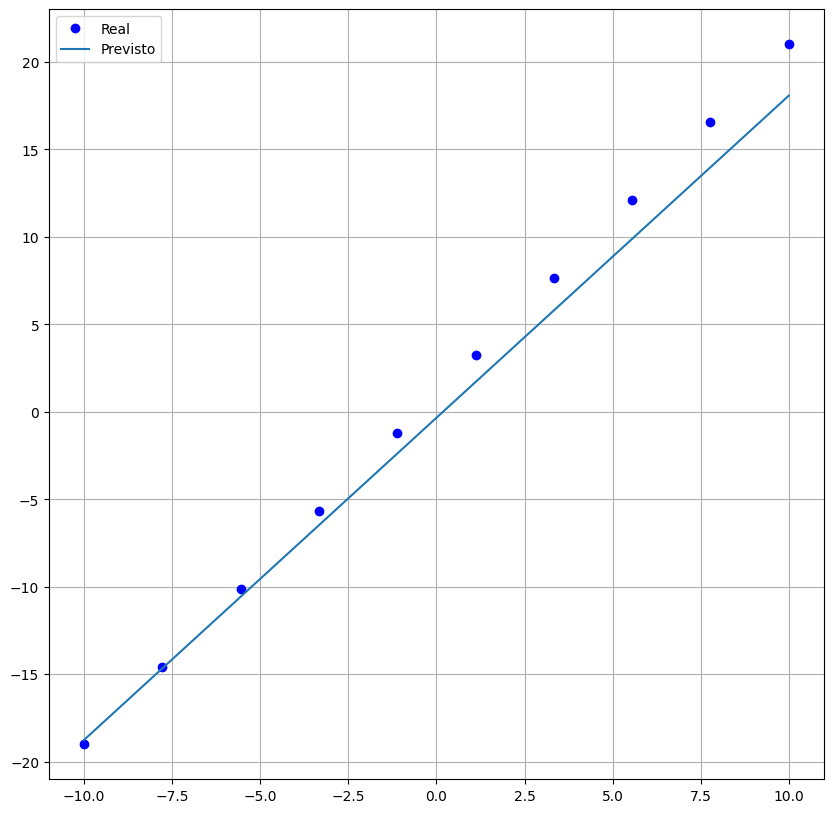

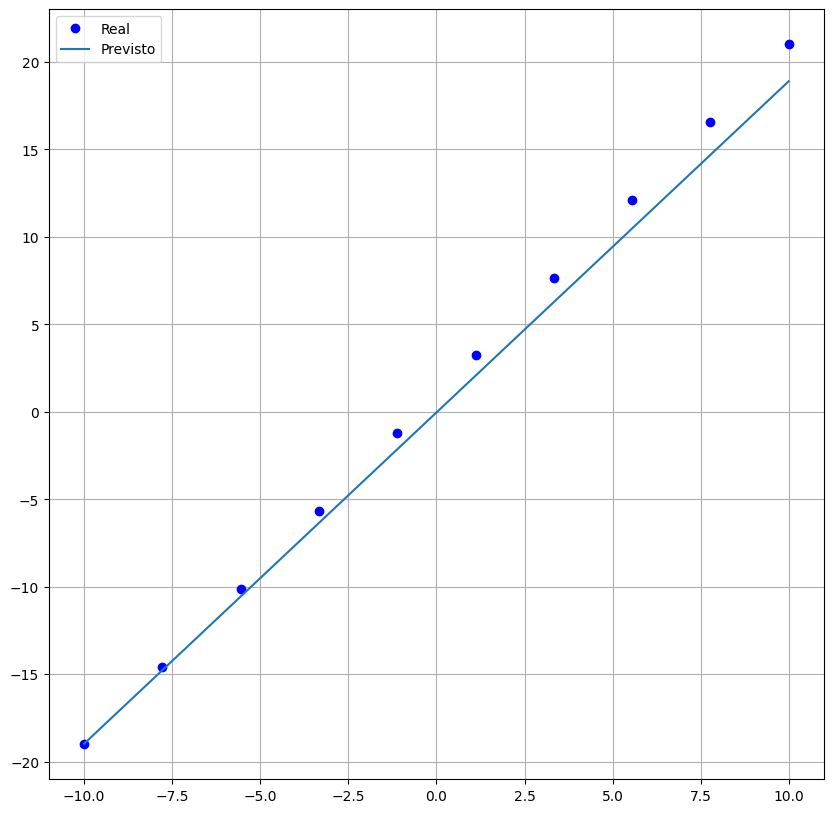

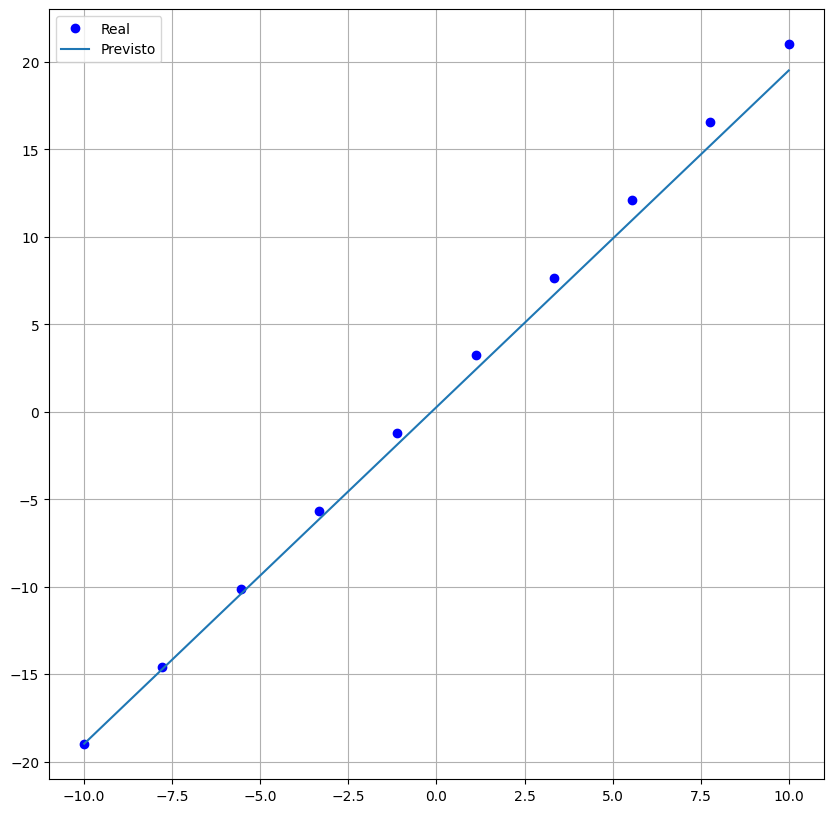

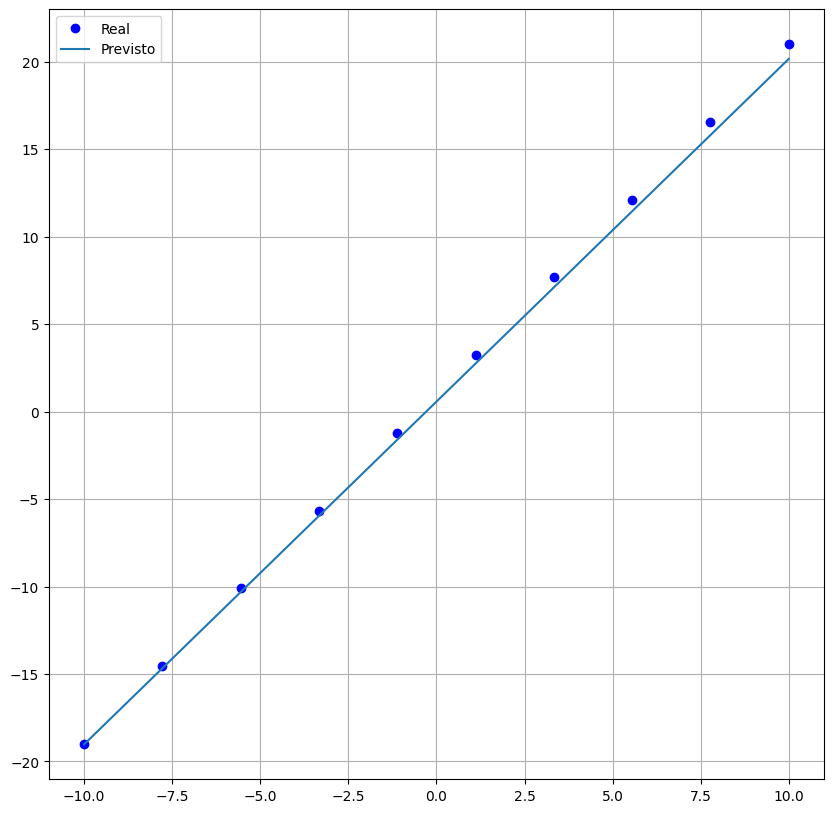

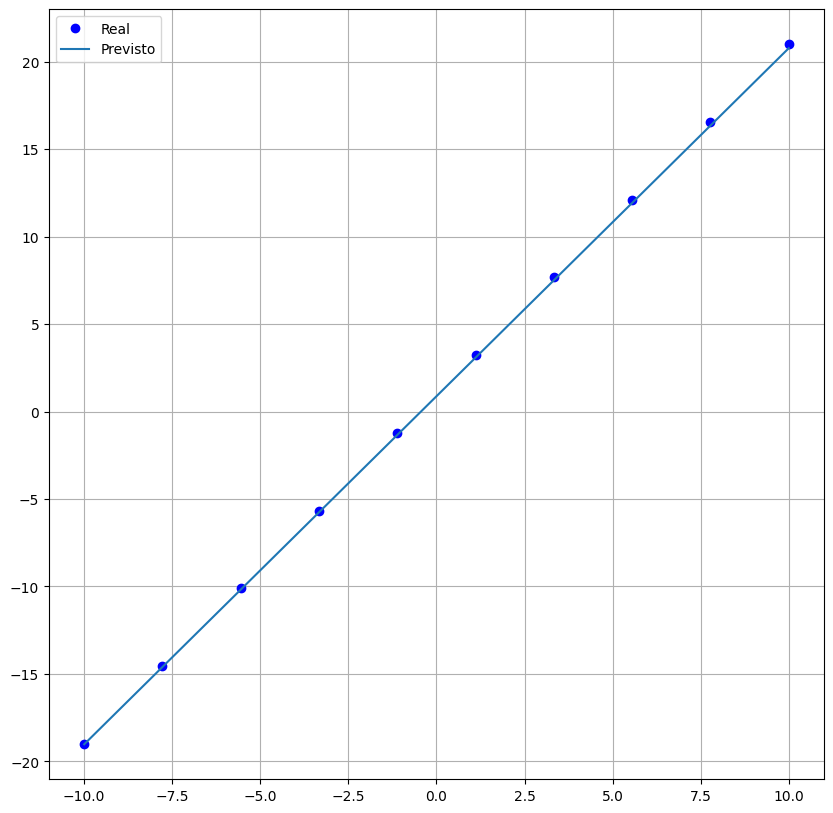

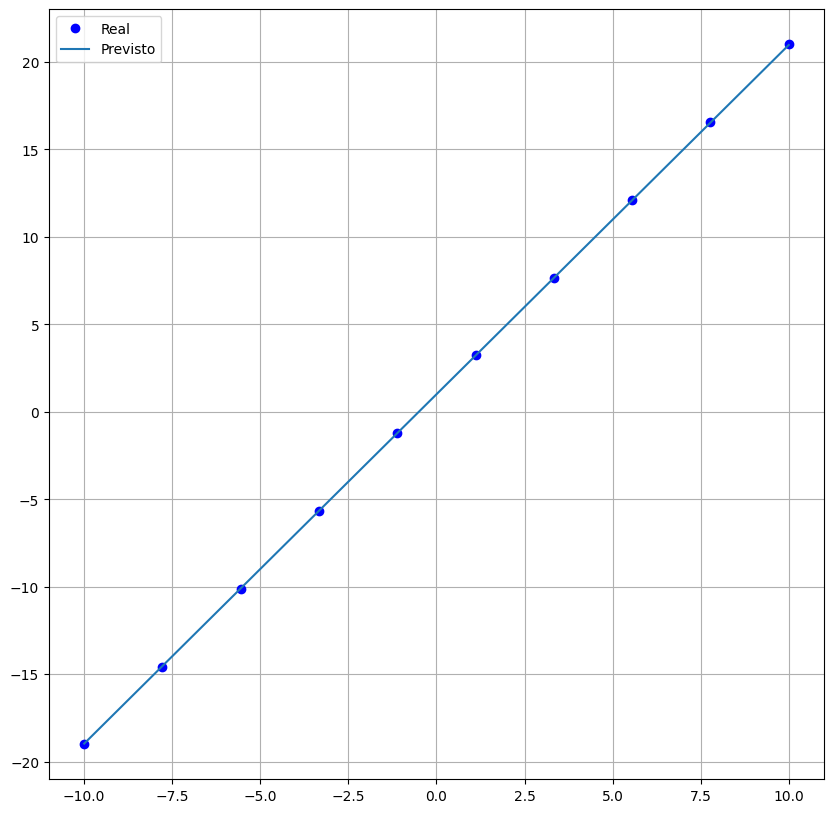

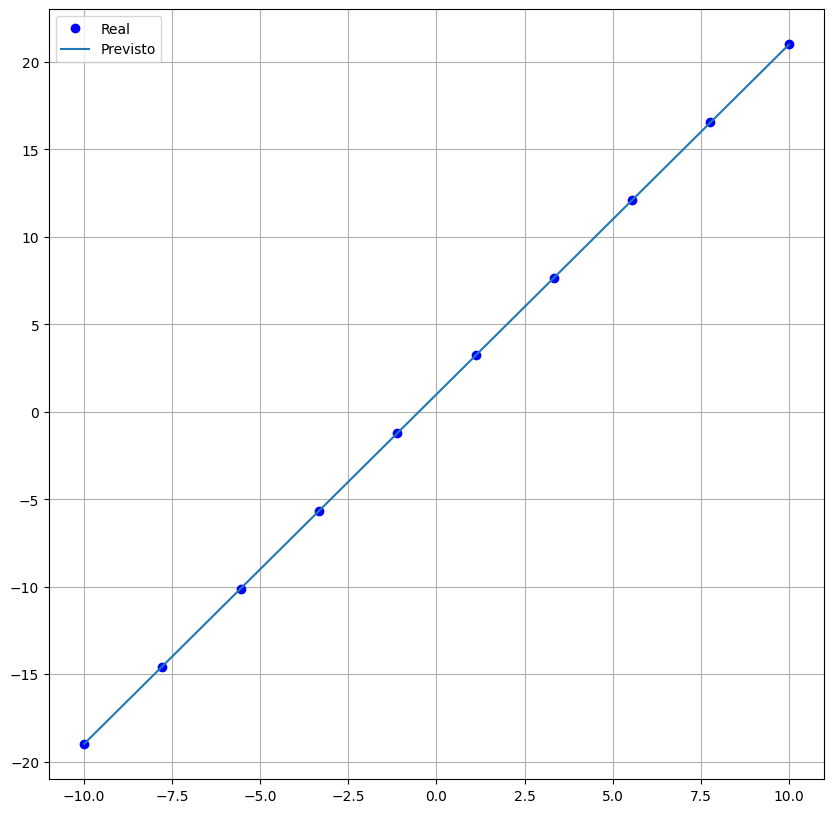

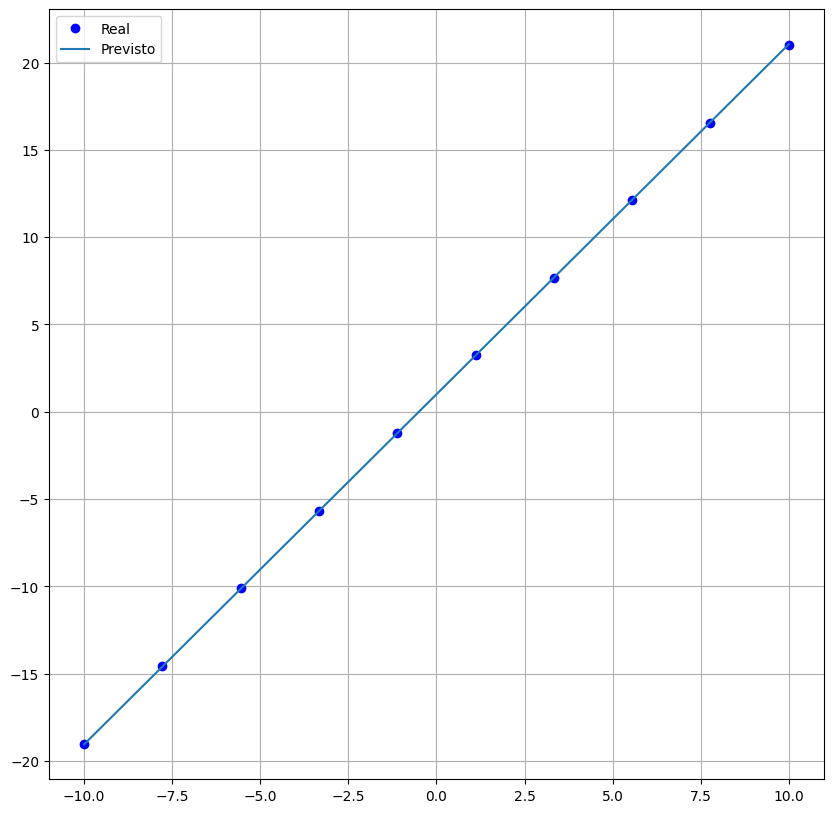

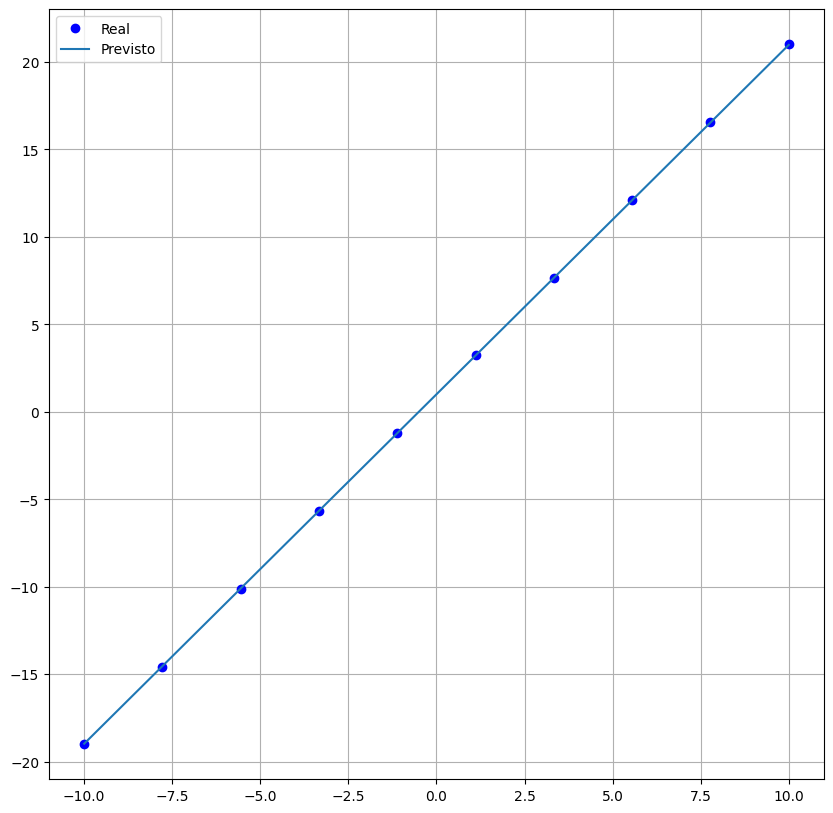

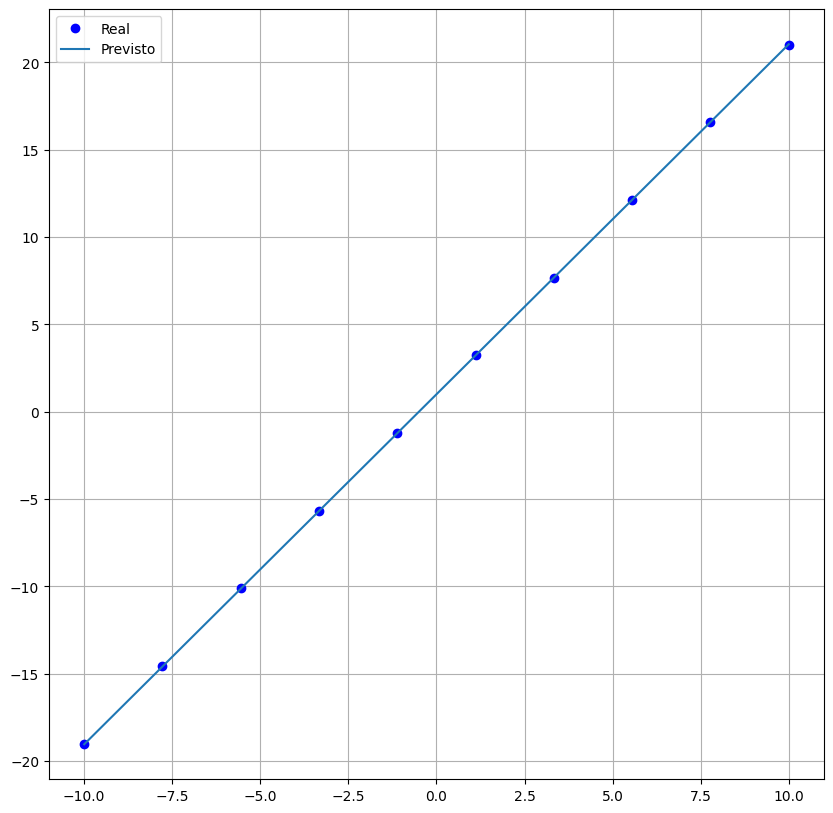

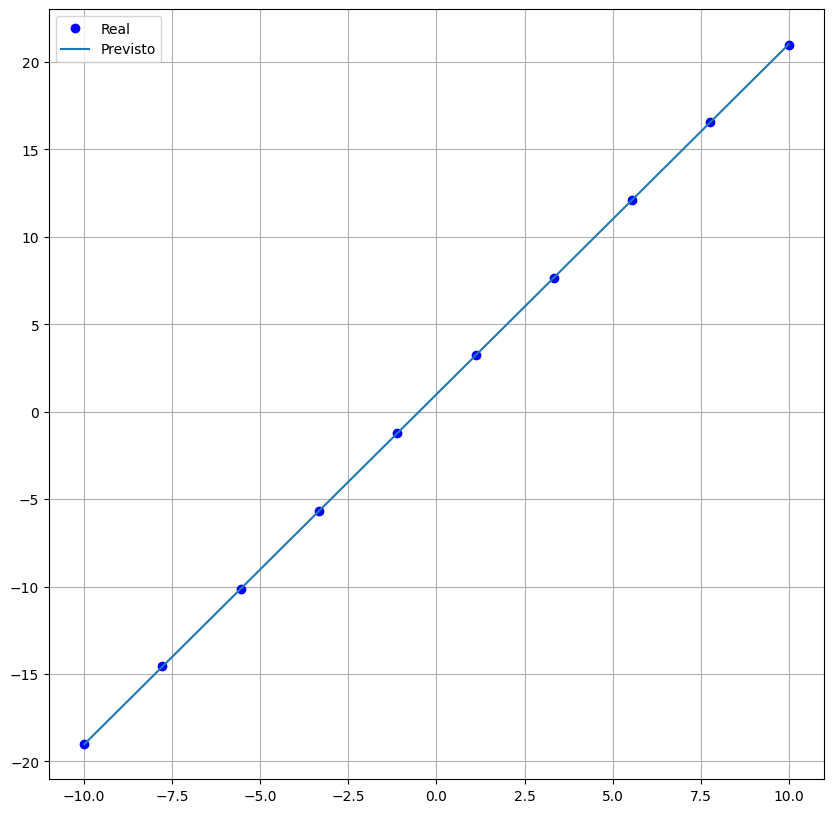

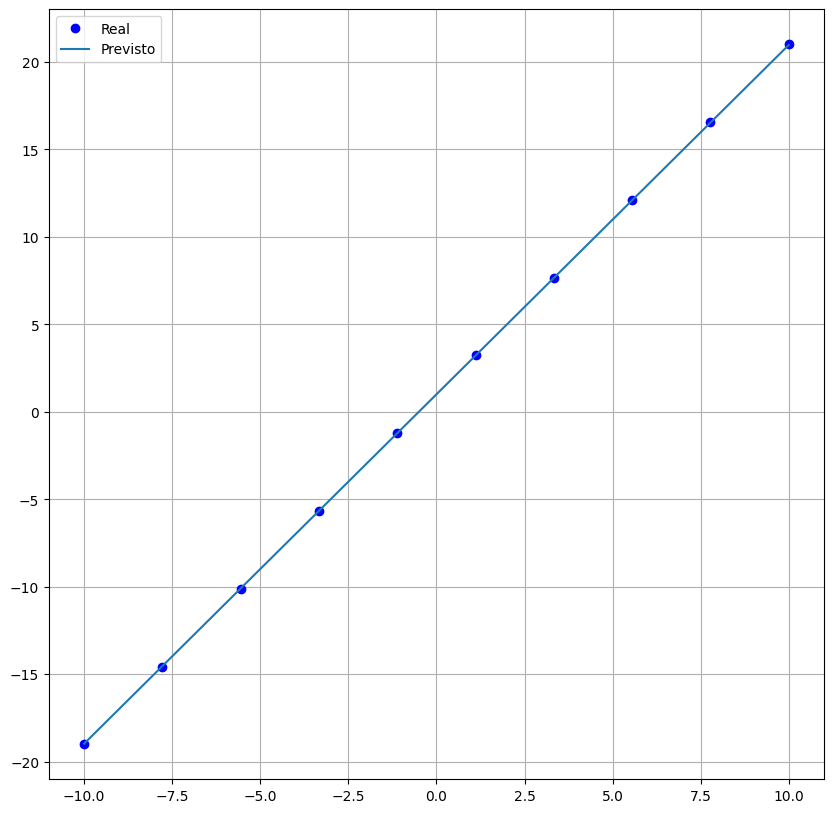

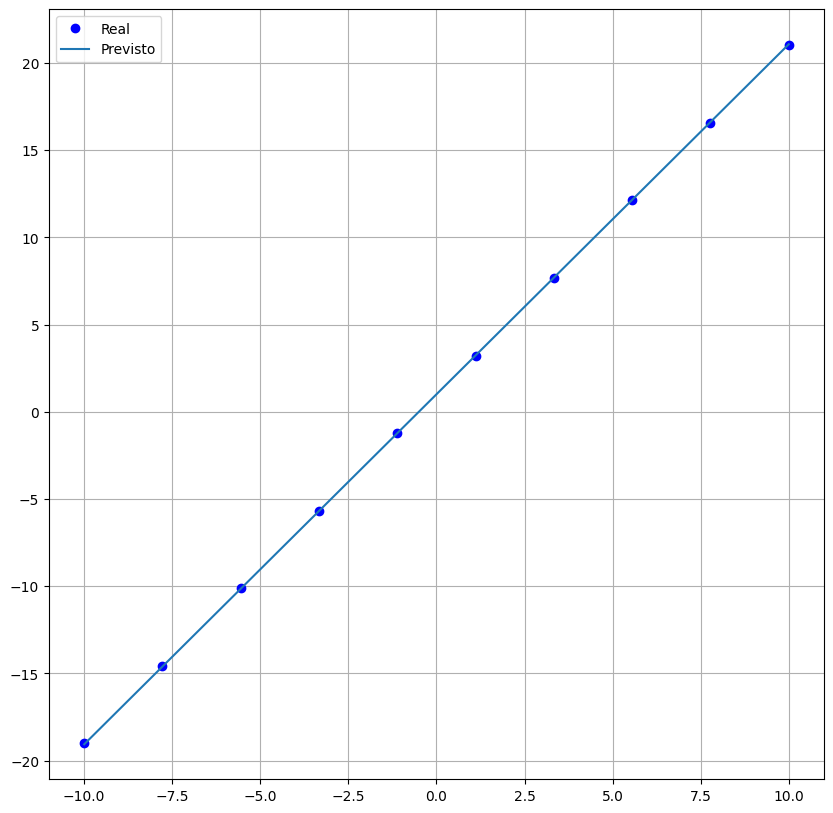

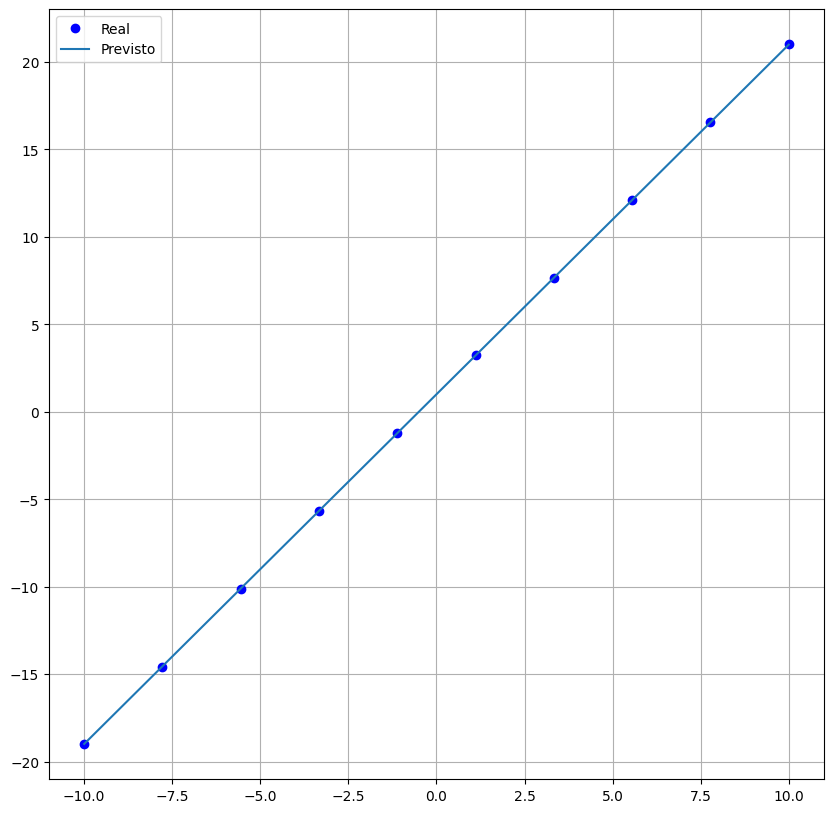

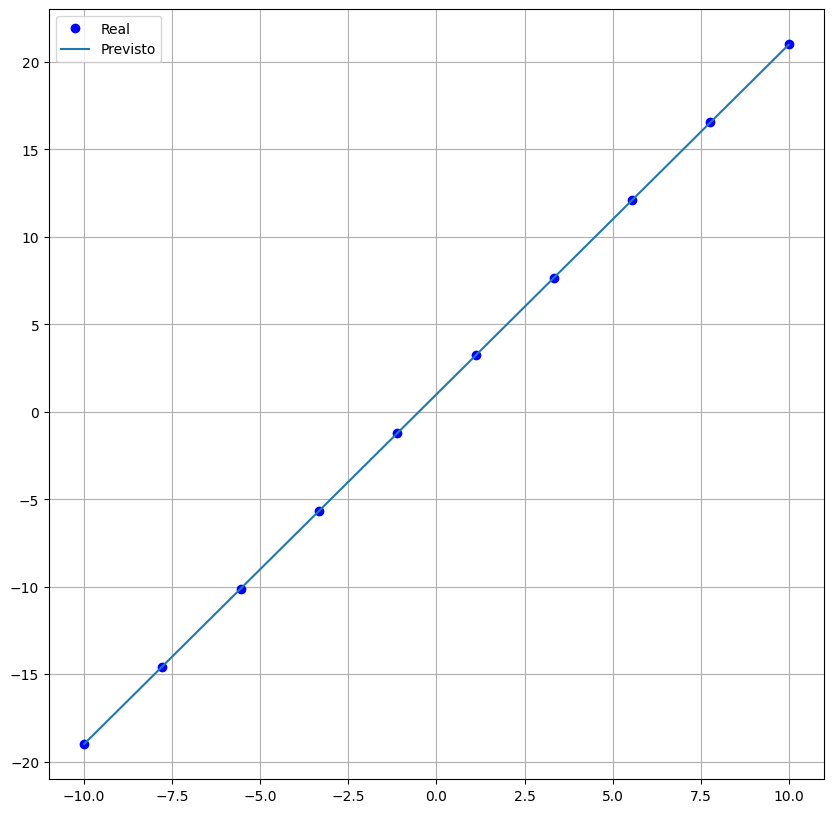

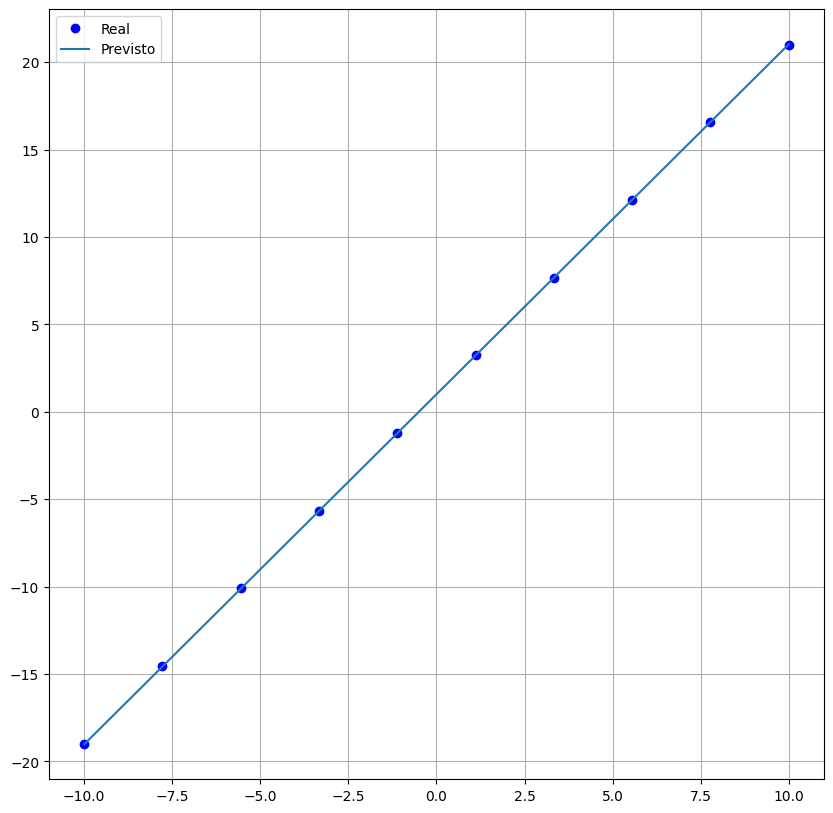

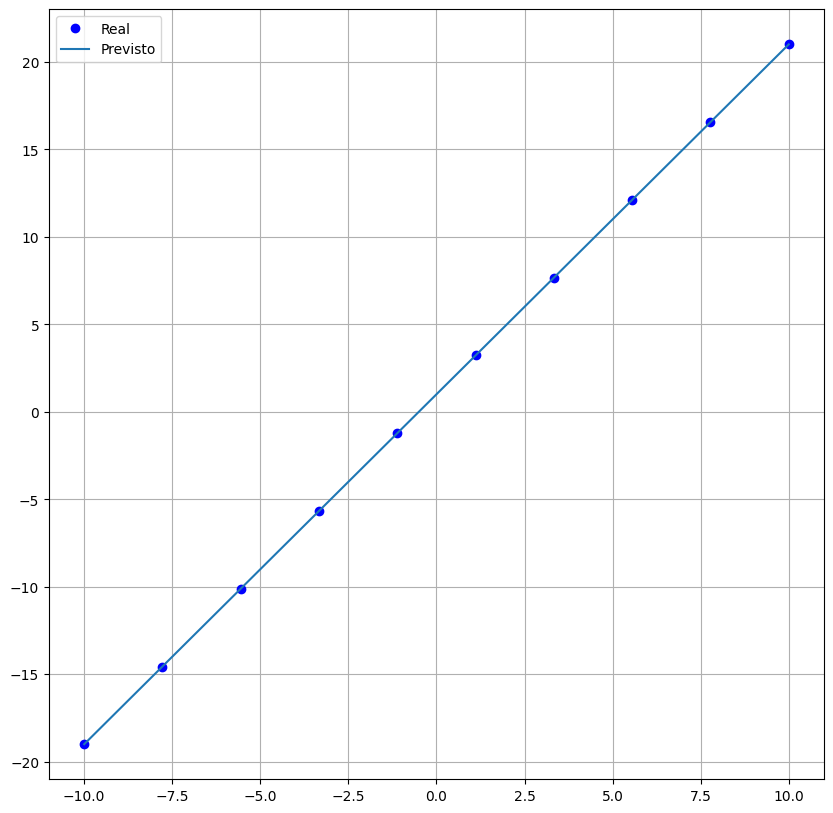

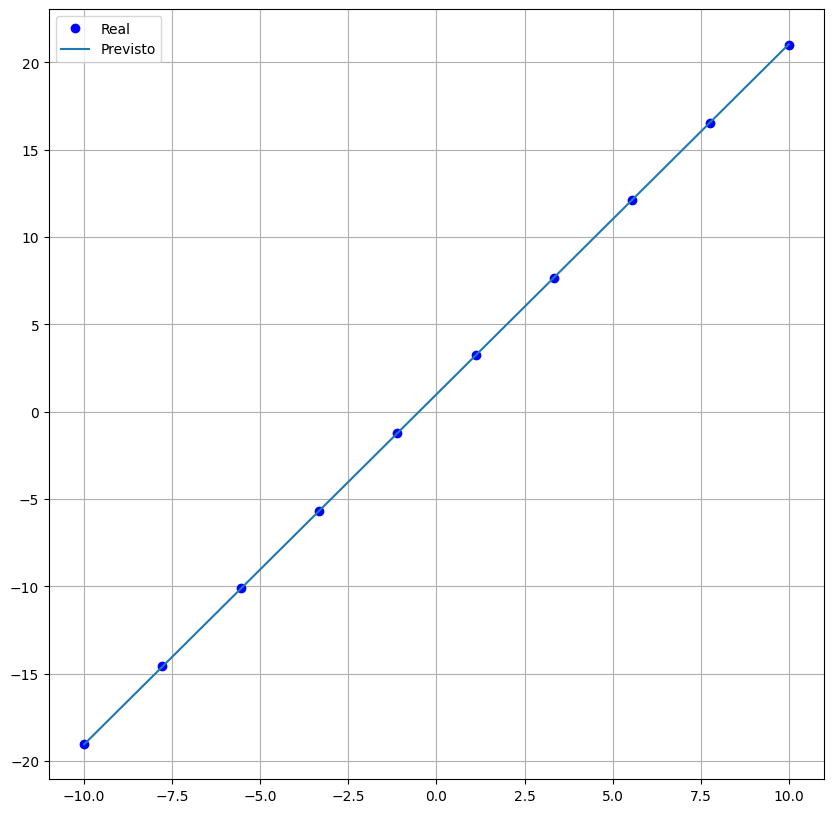

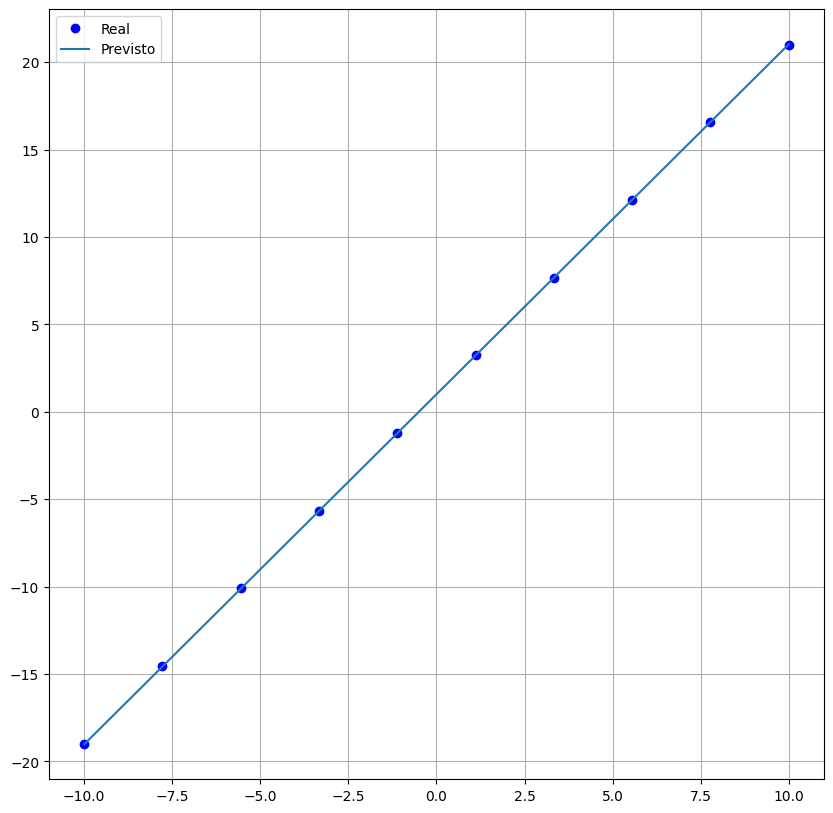

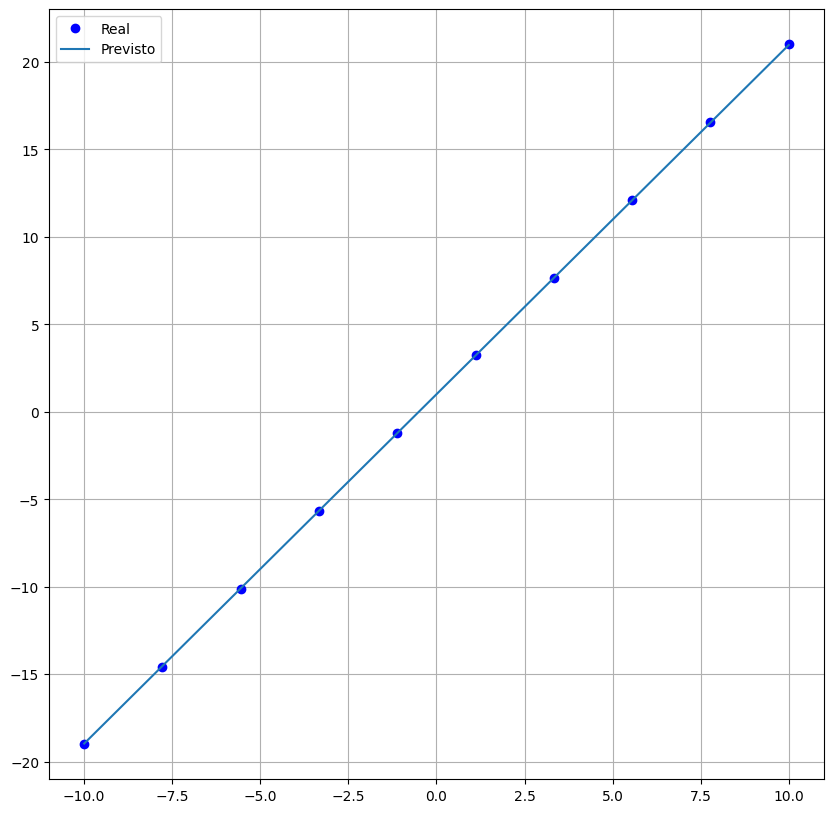

In [58]:
#epocas
epochs = 201

for t in range(epochs):
    train_loss = train(modelo, train_dataloader, loss_fn, optimizer)

    if((t % 10) == 0):
        print(f"Epoca {t} - Loss: {train_loss}")
        plot(line, modelo)


    test_loss = test( modelo, test_dataloader, loss_fn)